  5%|▌         | 1/20 [00:52<16:46, 52.97s/it]

epoch 01 | last loss=0.228939


 10%|█         | 2/20 [01:45<15:46, 52.58s/it]

epoch 02 | last loss=0.207252


 15%|█▌        | 3/20 [02:37<14:53, 52.53s/it]

epoch 03 | last loss=0.192903


 20%|██        | 4/20 [03:30<13:59, 52.46s/it]

epoch 04 | last loss=0.196098


 25%|██▌       | 5/20 [04:22<13:07, 52.51s/it]

epoch 05 | last loss=0.196288


 30%|███       | 6/20 [05:15<12:14, 52.47s/it]

epoch 06 | last loss=0.201434


 35%|███▌      | 7/20 [06:07<11:22, 52.46s/it]

epoch 07 | last loss=0.185964


 40%|████      | 8/20 [06:59<10:29, 52.43s/it]

epoch 08 | last loss=0.181864


 45%|████▌     | 9/20 [07:52<09:36, 52.37s/it]

epoch 09 | last loss=0.170465


 50%|█████     | 10/20 [08:44<08:43, 52.38s/it]

epoch 10 | last loss=0.187693


 55%|█████▌    | 11/20 [09:36<07:51, 52.35s/it]

epoch 11 | last loss=0.177883


 60%|██████    | 12/20 [10:29<06:59, 52.40s/it]

epoch 12 | last loss=0.164979


 65%|██████▌   | 13/20 [11:21<06:06, 52.42s/it]

epoch 13 | last loss=0.182558


 70%|███████   | 14/20 [12:13<05:14, 52.35s/it]

epoch 14 | last loss=0.159880


 75%|███████▌  | 15/20 [13:06<04:21, 52.39s/it]

epoch 15 | last loss=0.175329


 80%|████████  | 16/20 [13:59<03:29, 52.46s/it]

epoch 16 | last loss=0.179114


 85%|████████▌ | 17/20 [14:51<02:37, 52.48s/it]

epoch 17 | last loss=0.171766


 90%|█████████ | 18/20 [15:44<01:45, 52.52s/it]

epoch 18 | last loss=0.182566


 95%|█████████▌| 19/20 [16:36<00:52, 52.51s/it]

epoch 19 | last loss=0.176047


100%|██████████| 20/20 [17:29<00:00, 52.46s/it]

epoch 20 | last loss=0.167306


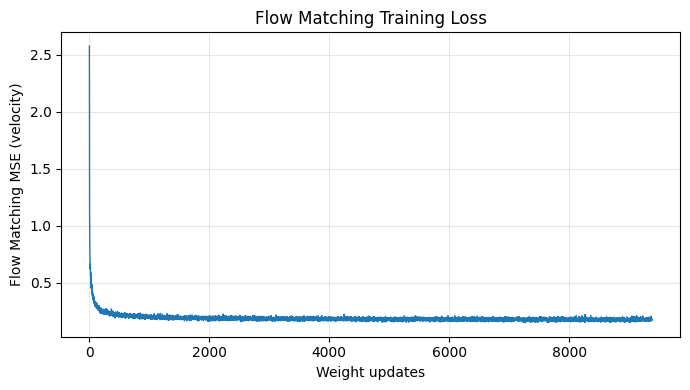

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2.0-1.0)
])
train_ds = datasets.MNIST(root="./data", train=True, transform=tfm, download=True)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, pin_memory=False) # Changed num_workers to 0 and pin_memory to False for debugging CUDA error

class DiffusionNoiseScheduler:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=2e-2, device='cpu'):
        self.T =T
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, T, device=device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.T, (batch_size,), device=self.device)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_ab = self.sqrt_alpha_bars[t].view(-1, 1, 1, 1)
        sqrt_1mab = self.sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)
        return sqrt_ab * x0 + sqrt_1mab * noise, noise

    @torch.no_grad()
    def show_noising_progress(sched, x0, timesteps=(0,50,100,200,400,700,999)):
        x0=x0.to(sched.device)
        imgs = []
        for t in timesteps:
            tt = torch.tensor([t], device=sched.device, dtype=torch.long)
            xt, _ = sched.q_sample(x0, tt)
            imgs.append(xt[0,0].detach().cpu())
        imgs = [(im+1)*0.5 for im in imgs]
        plt.figure(figsize=(len(timesteps)*2,2))
        for i, (t,im) in enumerate(zip(timesteps, imgs)):
            ax = plt.subplot(1, len(timesteps), i+1)
            ax.imshow(im, cmap='gray', vmin=0, vmax=1)
            ax.set_title(f't={t}')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scheduler = DiffusionNoiseScheduler(T=1000,device=device) # Corrected T from 200 to 1000
# x0, _ = next(iter(train_loader))
# x0 = x0.to(device)
# t=scheduler.sample_timesteps(x0.size(0))
# xt, eps = scheduler.q_sample(x0, t)
# DiffusionNoiseScheduler.show_noising_progress(scheduler, x0[:1].to(device))
# with torch.no_grad():
#     t = torch.tensor([scheduler.T - 1], device=device)
#     xt, _ = scheduler.q_sample(x0[0:1].to(device), t)
#     print("mean:", xt.mean().item(), "std:", xt.std().item())
#     print("alpha_bar[T-1] =", scheduler.alpha_bars[-1].item())
#     noise = torch.randn_like(xt)
#     print("noise mean:", noise.mean().item(), "noise std:", noise.std().item())


def sinusoidal_time_embedding(timesteps, dim, max_period=10000):
    half=dim//2
    freqs = torch.exp(-math.log(max_period) * torch.arange(0, half, device=timesteps.device).float()/half)
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(t_dim, out_ch)
        self.norm1=nn.GroupNorm(8, out_ch)
        self.norm2=nn.GroupNorm(8, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h) # Corrected: Used F.silu as self.act was undefined
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h+t
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h) # Corrected: Used F.silu as self.act was undefined
        return h + self.skip(x)

class Downsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        # Corrected: Use Conv2d for downsampling
        self.conv = nn.Conv2d(ch, ch, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(ch, ch, 4, stride=2, padding=1)

    def forward(self, x):
        return self.tconv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, t_dim=128):
        super().__init__()
        self.t_dim=t_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(t_dim, t_dim*4),
            nn.SiLU(),
            nn.Linear(t_dim*4, t_dim)
        )
        self.in_conv = nn.Conv2d(in_ch, base_ch, 3, padding=1)
        self.down1 = ResBlock(base_ch, base_ch, t_dim)
        self.ds1 = Downsample(base_ch)
        self.down2 = ResBlock(base_ch, base_ch*2, t_dim)
        self.ds2 = Downsample(base_ch*2)
        self.mid1 = ResBlock(base_ch*2, base_ch*2, t_dim)
        self.mid2 = ResBlock(base_ch*2, base_ch*2, t_dim)
        self.us2 = Upsample(base_ch*2)
        self.up2 = ResBlock(base_ch*4, base_ch*2, t_dim) # Corrected: in_ch for concat and out_ch for next stage
        self.us1 = Upsample(base_ch*2) # Corrected: input channels must match output of up2
        self.up1 = ResBlock(base_ch*3, base_ch, t_dim) # Corrected: in_ch for concat
        self.out_norm = nn.GroupNorm(8, base_ch)
        self.out_conv = nn.Conv2d(base_ch, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.t_dim)
        t_emb = self.time_mlp(t_emb)
        x0 = self.in_conv(x)
        d1 = self.down1(x0, t_emb)
        x1 = self.ds1(d1)
        d2 = self.down2(x1, t_emb)
        x2 = self.ds2(d2)
        m = self.mid1(x2, t_emb)
        m = self.mid2(m, t_emb)
        u2 = self.us2(m)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.up2(u2, t_emb)
        u1 = self.us1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up1(u1, t_emb)
        out = self.out_norm(u1)
        out = F.silu(out)
        eps_pred = self.out_conv(out)
        return eps_pred

    def train_ddpm_epoch(model, loader, sched, opt, device):
        model.train()
        total = 0.0
        n=0
        epoch_losses = []
        for x0, _ in loader:
            x0 = x0.to(device)
            B = x0.size(0)
            t = sched.sample_timesteps(B)
            xt, noise = sched.q_sample(x0, t)
            noise_pred = model(xt, t)
            loss = F.mse_loss(noise_pred, noise)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            total += loss.item()
            n+=1
            epoch_losses.append(loss.item())
        return total/max(n,1), epoch_losses

    def train_flowmatch_epoch(model, loader, opt, device, T_embed=1000):
        model.train()
        losses = []
        for x1, _ in loader:
            x1 = x1.to(device)
            B = x1.size(0)
            x0 = torch.randn_like(x1)              # noise prior
            t = torch.rand(B, device=device)        # [B] continuous
            # linear interpolation x(t)
            t_img = t.view(B, 1, 1, 1)
            xt = (1.0 - t_img) * x0 + t_img * x1
            # target velocity
            v_target = x1 - x0
            # integer timestep for embedding reuse
            ti = (t * (T_embed - 1)).long()
            v_pred = model(xt, ti)                 # [B,1,28,28]
            loss = F.mse_loss(v_pred, v_target)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            losses.append(loss.item())

        return losses


# all_losses = []
# steps = []
# step = 0
# epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_ch=1, base_ch=64, t_dim=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
# for epoch in trange(epochs):
#     loss, epoch_losses = UNet.train_ddpm_epoch(model, train_loader, scheduler, opt, device)
#     for l in epoch_losses:
#         step += 1
#         all_losses.append(l)
#         steps.append(step)
#     print(f"Epoch {epoch}, Loss: {loss:.4f}")

# plt.figure(figsize=(7,4))
# plt.plot(steps, all_losses, linewidth=1)
# plt.xlabel("Weight updates")
# plt.ylabel("MSE noise prediction loss")
# plt.title("DDPM Training Loss Curve")
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


all_losses_f = []
steps_f = []
step_f = 0
epochs_f = 20
for ep in trange(epochs_f):
    epoch_losses_f = UNet.train_flowmatch_epoch(model, train_loader, opt, device, T_embed=1000)
    for l in epoch_losses_f:
        step_f += 1
        all_losses_f.append(l)
        steps_f.append(step_f)
    print(f"epoch {ep+1:02d} | last loss={epoch_losses_f[-1]:.6f}")

plt.figure(figsize=(7,4))
plt.plot(steps_f, all_losses_f, linewidth=1)
plt.xlabel("Weight updates")
plt.ylabel("Flow Matching MSE (velocity)")
plt.title("Flow Matching Training Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


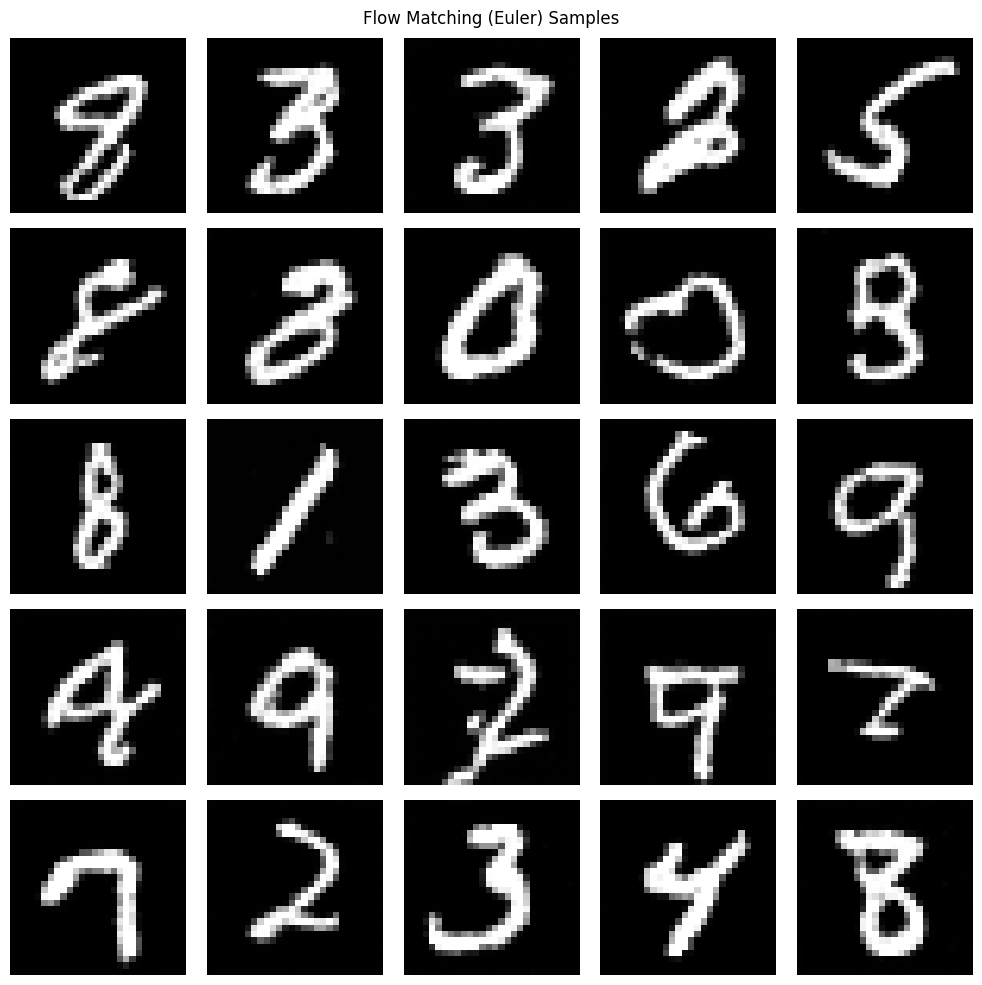

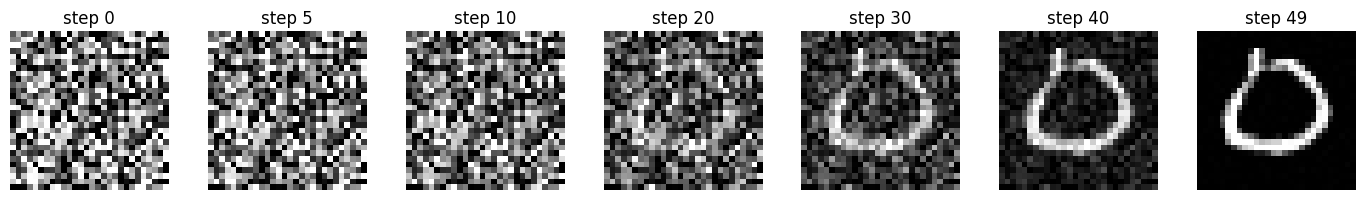

In [4]:
############################## FLOW MATCHING SAMPLING ##############################
@torch.no_grad()
def flowmatch_sample_euler(model, n=16, steps=50, device=None, T_embed=1000):
    model.eval()
    device = device or next(model.parameters()).device
    x = torch.randn(n, 1, 28, 28, device=device)  # x(0) ~ N(0,I)
    for k in range(steps):
        t = torch.full((n,), k / steps, device=device)      # [0,1)
        ti = (t * (T_embed - 1)).long()
        v = model(x, ti)
        dt = 1.0 / steps
        x = x + dt * v
    return x

@torch.no_grad()
def flowmatch_sample_heun(model, n=16, steps=50, device=None, T_embed=1000, capture_ts=None):
    model.eval()
    device = device or next(model.parameters()).device
    x = torch.randn(n, 1, 28, 28, device=device)
    snaps = {} if capture_ts is not None else None
    capture_set = set(capture_ts) if capture_ts is not None else set()
    for k in range(steps):
        t = torch.full((n,), k / steps, device=device)
        ti = (t * (T_embed - 1)).long()
        v1 = model(x, ti)
        dt = 1.0 / steps
        x_euler = x + dt * v1
        t2 = torch.full((n,), (k + 1) / steps, device=device).clamp(max=1.0)
        ti2 = (t2 * (T_embed - 1)).long()
        v2 = model(x_euler, ti2)
        x = x + dt * 0.5 * (v1 + v2)
        if snaps is not None and k in capture_set:
            snaps[k] = x.detach().clone()
    return (x, snaps) if snaps is not None else (x, None)

def to_display(x):
    x = x.clamp(-1, 1)
    return ((x + 1) * 0.5).cpu().numpy()  # [0,1]

def show_samples_grid(x, title="Flow Matching Samples"):
    imgs = to_display(x)
    N = imgs.shape[0]
    cols = int(np.ceil(np.sqrt(N)))
    rows = int(np.ceil(N / cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(rows*cols):
        ax = plt.subplot(rows, cols, i+1)
        ax.axis("off")
        if i < N:
            ax.imshow(imgs[i,0], cmap="gray", vmin=0, vmax=1)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Final samples
x_gen = flowmatch_sample_euler(model, n=25, steps=50, device=device, T_embed=1000)
show_samples_grid(x_gen, title="Flow Matching (Euler) Samples")

# capture a few steps
capture_steps = [0, 5, 10, 20, 30, 40, 49]
x_final, snaps = flowmatch_sample_heun(model, n=8, steps=50, device=device, T_embed=1000, capture_ts=capture_steps)
plt.figure(figsize=(2*len(capture_steps), 2))
for i, k in enumerate(capture_steps):
    ax = plt.subplot(1, len(capture_steps), i+1)
    ax.axis("off")
    ax.imshow(to_display(snaps[k][0:1])[0,0], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"step {k}")
plt.tight_layout()
plt.show()